# Trying Out Different Types of Encoding

How we choose to encode the various types of features availabe in the dataset dictate how well the prediction algorthim can perform. Encoding schemes provide a few challenges.
1. A lot of the feature data has a very large number of categories. Keeping all of them is impossible. Training a regressor on a such a sparse matrix will not yield any valid results. Thus we need to keep only the important categories and drop the rest. We need to come to a trade-off in how many categories we choose and how we choose them.
2. The dataset includes datetime data. We need a way to process it in such way that makes sense and helps with the predictions
3. The dataset hass missing data which have been imputed before reaching the encoding stage. So the encoding scheme has to be robust enough so that any single feature does not dominate the output

Figuring out a scheme that deals with all of these challenges at once is a difficult task. So to make the problem a bit simpler we make some assumptions.
1. The features are independent
2. We choose a XGBoost regressor, try a 5-fold cross-validation using MSE as the scoring parameter and we base the judgement of our encoding scheme based on the mean and the variance of the MSE score from these 5 trials. In otherwords, a good model should have a low mean of MSEs over each of the cross-validation trials. This resembles a low bias. The variance between these MSEs should also be low. This resembles a low variance
(Quick Note about Cross-Validation: for CV, we split the dataset into k-folds, train our model with (k-1) folds of the data and measure its MSE against the remaining test fold. We do this process k times with a different testing set each turn while also resetting the model at the beginning of each trial. By default, we set k to 5 for time considertaions. A larger value would give us more precise values but also would take longer computation time)

Based on these assumptions, we take the feature columns one at a time and drop the rest and train regressor based on this. We try out different encoding schemes and vary the N parameter(How many categories to keep per feature) within a reasonable range and compare them with each other as well as with the no categories dropped condition.

## Working With Categorical Features 

This includes features such as a movie/show's 'Genre', 'Tags', 'Languages', 'Regions Available' and so on. On top of the vanilla one multi-category one-hot encoding we try a few more encoding methods and vary the N. 
1. Keep all N-top most occuring categories. Given the data, we calculate which categories have the highest occurances, and only keep those in the encoding scheme. Any other categories are regarded as the 'zero - class'. An entry might have multiple of these most-occuring categories. In that case, we keep them all. (Extra: if a class has multiple categories, lowering N will take them out one by one until there is only one category left per entry)

2. Keep N-top most impactful categories. This encoder goes over the data and groups it by category and then calculates the average value of the resultant/target varible for each group independently. Essentially, it's a measure of how much a single category would affect the target. Then we only keep the categories with the highest average and drop the rest. 

### A Baseline

In [1]:
# Before Starting up anything, we need to add the folder containing all the source code to Jupyter Notebooks
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\project_code")

In [2]:
from encoding import *
from sklearn.ensemble import GradientBoostingRegressor
from method_evaluation import evaluate_model
from missingdata import *
from exploration_helper_functions import *

data_path = Path(r'data/netflix_data.csv')
scheme = {'Genre': DropColumn(),
          'Tags': DropColumn(),
          'Languages': DropColumn(),
          'Series or Movie': DropColumn(),
          'Country Availability': DropColumn(),
          'Runtime': DropColumn(),
          'Director': DropColumn(),
          'Writer': DropColumn(),
          'Actors': DropColumn(),
          'Awards Received': DropColumn(),
          'Awards Nominated For': DropColumn(),
          'Release Date': DropColumn(),
          'Netflix Release Date': DropColumn(),
          'Production House': DropColumn(),
          }
categories_to_replace = ['Genre', 'Tags', 'Languages', 'Series or Movie', 'Country Availability', 'Runtime', 'Director',
                         'Writer', 'Actors']
encoding_schemes = [OneHot()]

mean_matrix = np.zeros((len(categories_to_replace), len(encoding_schemes)))
var_matrix = np.zeros_like(mean_matrix)
# Model
reg = GradientBoostingRegressor(random_state=42, n_estimators=120)
df = load_data(data_path)
imputer = DataImputer()
imputer.fit_transform(df)

In [4]:
for i, category in enumerate(categories_to_replace):
    for j, encoding_scheme in enumerate(encoding_schemes):
        # Replace the corresponding column encoding scheme
        scheme.update({category: encoding_scheme})
        encoder = DataEncoder(scheme=scheme)
        x, y = encoder.fit_transform(dataframe=df)
        mean, var = evaluate_model(reg, x, y)
        mean_matrix[i, j] = mean
        var_matrix[i, j] = var
        scheme.update({category: DropColumn()})

Text(0.5, 1.0, 'Prediction Using Only a Single Column But with All Categories Accounted for')

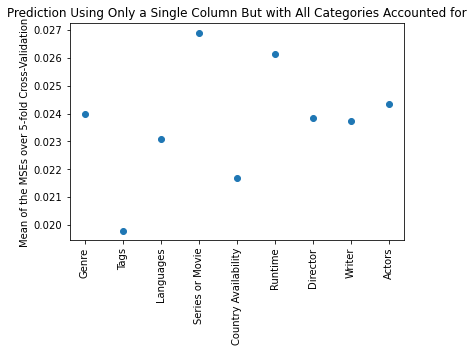

In [14]:
import matplotlib.pyplot as plt

plt.plot(categories_to_replace, mean_matrix, 'o')
plt.xticks(rotation='vertical')
plt.ylabel("Mean of the MSEs over 5-fold Cross-Validation")
plt.title("Prediction Using Only a Single Column But with All Categories Accounted for")

Text(0, 0.5, 'Variance of the MSEs over 5-fold Cross-Validation')

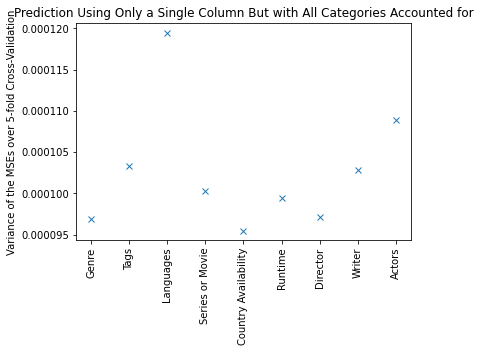

In [15]:
plt.title("Prediction Using Only a Single Column But with All Categories Accounted for")
plt.plot(categories_to_replace, var_matrix, 'x')
plt.xticks(rotation='vertical')
plt.ylabel("Variance of the MSEs over 5-fold Cross-Validation")

The two curves above show the performance of the vanilla multi-category one hot encoder for working with column at a time. The first curve shows the mean of the MSEs for our XGBoost model for the 5-fold CV. The second one shows the variance in those MSEs. We take these as the baseline since they do not drop any of the categories. ALthough the mean of MSE is really low, this method tends to overfit and display a high variance. This is also an artifact of having such a large number of categories. 

Another takeaway from these plots are how well each individual column can fit the data. For example, the "Country Availability" feature has both low mean and variance meaning it is a very good estimator of how much reach any movie/show will get. From common sense that makes sense. If a show is available in countires with more viewers, it will definitely have a larger audience. The same goes for the "Tag" parameter. Meaning specific tags would net you higher viewers. On the other end of the spectrum we see that "Movie/Series" has a very large mean MSE. This gives a hint that whether your show is a movie or series does not impact reach as much say the other features.

### Performance of Different Encoders Visualized Per Category


In [65]:
N = [1, 5, 10, 15, 20, 25, 30, 35, 40]
encoding_schemes2 = [KeepTopN(n) for n in N] 

mean_matrix_2 = np.zeros((len(categories_to_replace), len(encoding_schemes2)))
var_matrix_2 = np.zeros_like(mean_matrix_2)

for i, category in enumerate(categories_to_replace):
    for j, encoding_scheme in enumerate(encoding_schemes2):
        # Replace the corresponding column encoding scheme
        scheme.update({category: encoding_scheme})
        encoder = DataEncoder(scheme=scheme)
        x, y = encoder.fit_transform(dataframe=df)
        mean, var = evaluate_model(reg, x, y)
        mean_matrix_2[i, j] = mean
        var_matrix_2[i, j] = var
        scheme.update({category: DropColumn()})

In [66]:
encoding_schemes3 = [TargetPriorityNEncoding(n) for n in N]
mean_matrix_3 = np.zeros((len(categories_to_replace), len(encoding_schemes3)))
var_matrix_3 = np.zeros_like(mean_matrix_3)

for i, category in enumerate(categories_to_replace):
    for j, encoding_scheme in enumerate(encoding_schemes3):
        # Replace the corresponding column encoding scheme
        scheme.update({category: encoding_scheme})
        encoder = DataEncoder(scheme=scheme)
        x, y = encoder.fit_transform(dataframe=df)
        mean, var = evaluate_model(reg, x, y)
        mean_matrix_3[i, j] = mean
        var_matrix_3[i, j] = var
        scheme.update({category: DropColumn()})

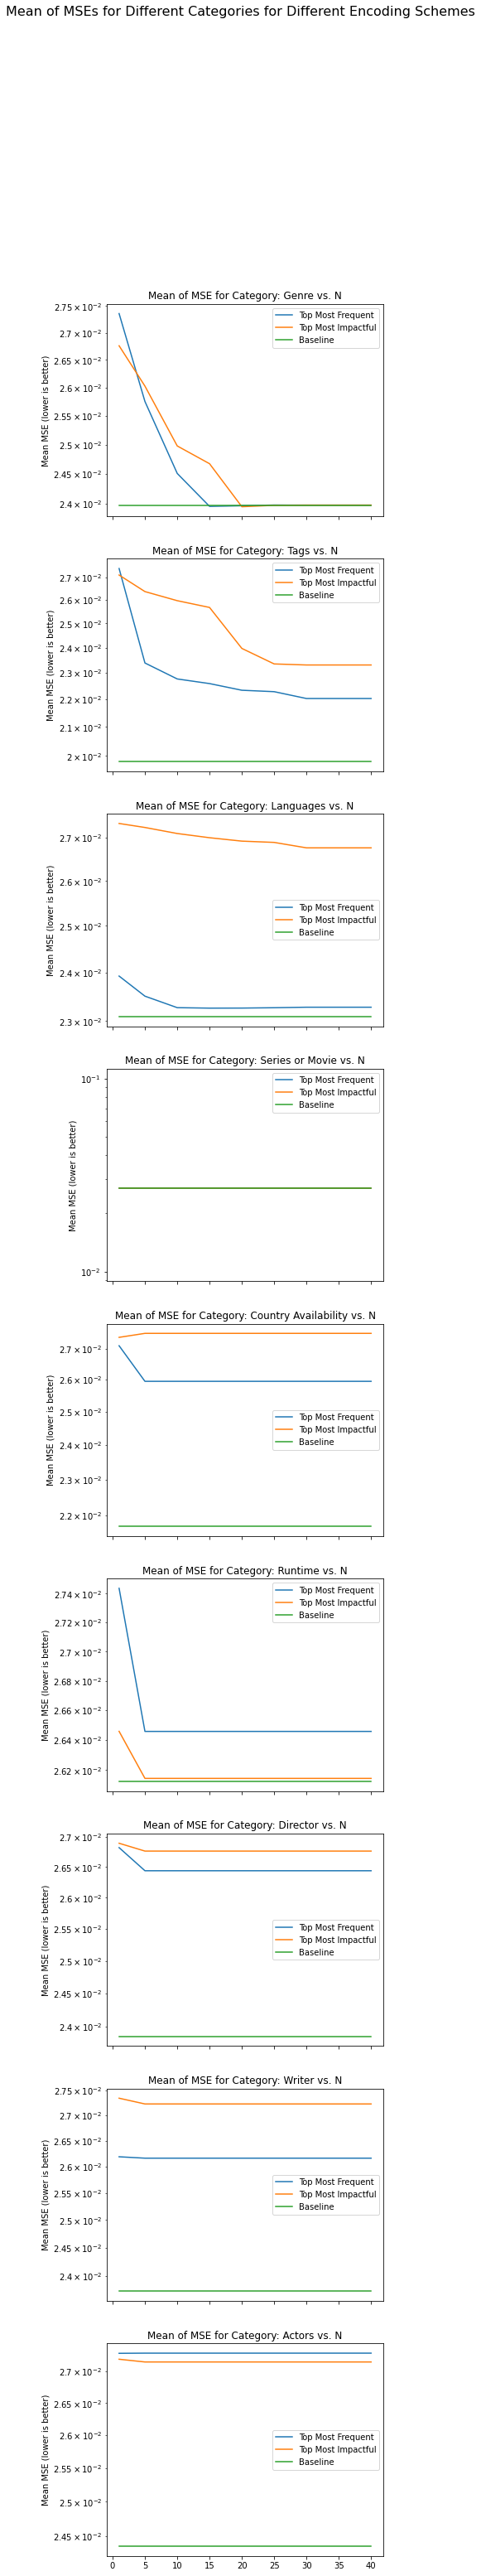

In [67]:
# Getting Plot Ready

fig, ax = plt.subplots(len(categories_to_replace), 1, sharex='col')
fig.suptitle('Mean of MSEs for Different Categories for Different Encoding Schemes', fontsize=16)
fig.set_figheight(50.)
for index, category in enumerate(categories_to_replace):
    ax[index].plot(N, mean_matrix_2[index, :])
    ax[index].plot(N, mean_matrix_3[index, :])
    ax[index].plot(N, [mean_matrix[index, 0]]*len(N))
    ax[index].legend([f"Top Most Frequent", f"Top Most Impactful", "Baseline"])
    ax[index].set_title(f"Mean of MSE for Category: {category} vs. N")
    ax[index].set_ylabel("Mean MSE (lower is better)")
    ax[index].set_yscale('log')

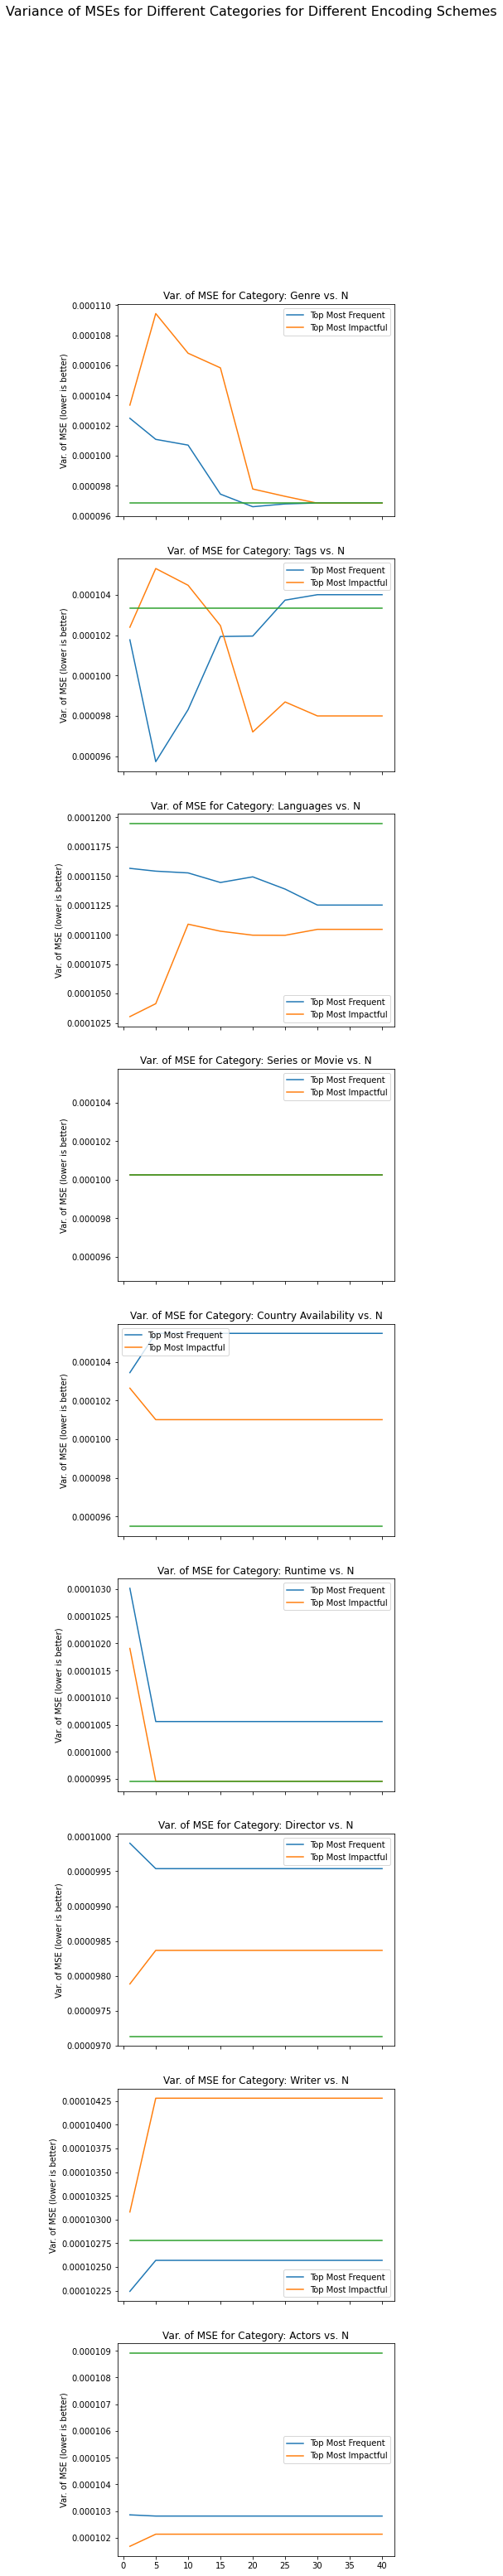

In [68]:
# Getting Plot Ready

fig, ax = plt.subplots(len(categories_to_replace), 1, sharex='col')
fig.suptitle('Variance of MSEs for Different Categories for Different Encoding Schemes', fontsize=16)
fig.set_figheight(50.)
for index, category in enumerate(categories_to_replace):
    ax[index].plot(N, var_matrix_2[index, :])
    ax[index].plot(N, var_matrix_3[index, :])
    ax[index].plot(N, [var_matrix[index, 0]]*len(N))
    ax[index].legend([f"Top Most Frequent", f"Top Most Impactful"])
    ax[index].set_title(f"Var. of MSE for Category: {category} vs. N")
    ax[index].set_ylabel("Var. of MSE (lower is better)")

The first thing to notice from these plots is that the errors pretty much flatten out for N greater than 10 - 20. So we can actually just work with *N = 20* for the regression and assuming we have a large enough dataset, we should be able to capture the correct features!

Another interesting thing is that for the extremely sparse features like "Actors", "Directors" and "Writers", the error curves flatten out as early as *N=5*. This essentially means that except the top few actors/writers/directors, the reach of a show/movie does not depend greatly on its cast/crew.  

The Baseline contians all categories for a given feature and its going to be impmossible to fit or even work with the data when we consider all the features. So even though the baseline does have the lowest errors, it is not something we can use. Also, for some of the features, the other encoding methods actually have a lower variance since those are calculating lower ammount of categories. 

Surprisingly, we see that in almost every case the error for the "Top Most Frequenct" is lower than "Top Most Impactful".  However "Top Most Frequent" also shows large variance. 

Despite this, for most categories, the variance is around the range of *1e-4*. Using this value and the values used for standardization, this corresponds to roughly a std. deviation of *15.34*. Whereas our surrogate variable for the reach, has a max value of roughly *235,000* and a mean of *43,000*. Considering these values, our variance is extremely small. So for the rest of the analysis we will use Top-20 most Frequent Categories for all the features. 

The project code actually has these as the default schemes!

## DateTime Data


We have 2 different datetime data included for the dataset. THe 'Release Date' and the 'Netflix Release Date'. Plotting the viewer data vs. datatime shows us a that there is a monthly as well as a yearly correlation in the data. For the majority of this section, we'll work with the Show's *Release Date* rather than its' Netflix Release date 

(0.0, 50000.0)

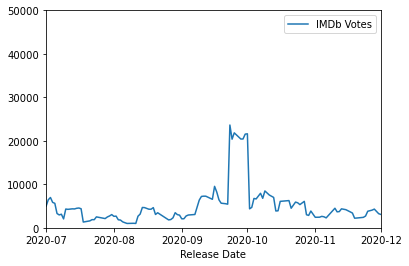

In [5]:
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

date_data = df[['Release Date', 'IMDb Votes']].copy()
date_data.dropna(inplace=True)
date_data['Release Date'] = date_data['Release Date'].map(lambda string: datetime.datetime.strptime(string, "%d %b %Y"))
# Taking the mean for all shows released on the same day
date_data = date_data.groupby(by=['Release Date']).mean()
# Taking a rolling mean over 7 days
date_data= date_data.rolling(7).mean()

lower_limit = datetime.datetime.strptime('1 Jul 2020', "%d %b %Y")
upper_limit = datetime.datetime.strptime('1 Dec 2020', "%d %b %Y")

sns.lineplot(data=date_data)
plt.xlim([lower_limit, upper_limit])
plt.ylim([0., 50000])

### Trying out Year Encodings

The year is encoded as an offset from a chosen year and then normalized between 0 to 1. Below we tried out the performance of our model without the datetime data and with the datetime data using different offset years. For the rest of columns, we use the best encoding we have found so far(saved as the defaults in the code so they do not need to be explicitly specified).

A quick formula for the year encoding
$$
Encoded Data = (Year - Offset)/Normalization Factor
$$
Where the normalizing factor is chosen to make the offset year be encoded to 0.0 and the most recent year(2021) to be encoded to 1.0 

In [6]:
from exploration_helper_functions import *
from encoding import *
from sklearn.ensemble import GradientBoostingRegressor
from method_evaluation import evaluate_model
from missingdata import DataImputer

data_path = Path(r'data/netflix_data.csv')
scheme = {
          'Release Date': DropColumn(),
          'Netflix Release Date': DropColumn(),
          }
categories_to_replace = ['Release Date']
encoding_schemes = [DropColumn(),
                    DateEncoding(format_string=r"%d %b %Y", year_offset=0),
                    DateEncoding(format_string=r"%d %b %Y", year_offset=1900),
                    DateEncoding(format_string=r"%d %b %Y", year_offset=2000)]

mean_matrix = np.zeros((len(categories_to_replace), len(encoding_schemes)))
var_matrix = np.zeros_like(mean_matrix)
# Model
reg = GradientBoostingRegressor(random_state=42, n_estimators=120)
df = load_data(data_path)
imputer = DataImputer()
imputer.fit_transform(df)

for i, category in enumerate(categories_to_replace):
    for j, encoding_scheme in enumerate(encoding_schemes):
        # Replace the corresponding column encoding scheme
        scheme.update({category: encoding_scheme})
        encoder = DataEncoder(scheme=scheme)
        x, y = encoder.fit_transform(dataframe=df)
        mean, var = evaluate_model(reg, x, y)
        mean_matrix[i, j] = mean
        var_matrix[i, j] = var
        scheme.update({category: DropColumn()})



Text(0.5, 1.0, 'Evaluation of Different Datetime Encoding Schemes')

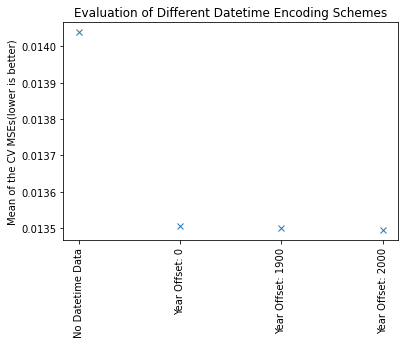

In [11]:
plt.plot(["No Datetime Data", "Year Offset: 0", "Year Offset: 1900", "Year Offset: 2000"], mean_matrix.flatten(), 'x')
plt.xticks(rotation='vertical')
plt.ylabel("Mean of the CV MSEs(lower is better)")
plt.title("Evaluation of Different Datetime Encoding Schemes")

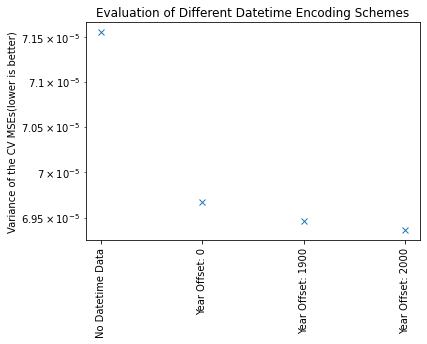

In [12]:
plt.plot(["No Datetime Data", "Year Offset: 0", "Year Offset: 1900", "Year Offset: 2000"], var_matrix.flatten(), 'x')
plt.xticks(rotation='vertical')
plt.ylabel("Variance of the CV MSEs(lower is better)")
plt.title("Evaluation of Different Datetime Encoding Schemes")
plt.yscale('log')

We notice 2 things from here.
1. Having the Datetime data does indeed give us a better prediction both in terms of bias and variance. Even though the impact is not very high 
2. Having the year offset set to values around 2000 yeild better results than no offset at all(0)

### Month and Day Encodings

From the above plots for 'IMDb votes' vs 'Release Date', we a type of trend with the day of the month. To encode this type of feature, the day is encoded as an ordinal variable with values between (0, 1] signifying the start and the end of the month. We tried two different month encodings.
1. Encoding the month as a One Hot vector
2. Encoding the month as an Ordinal variable between (0, 1] (0 excluded)
(The rest of the encoding scheme is kept to the defaults with the year offset being 2000)

The results are shown below

In [ ]:
from encoding import *

categories_to_replace = ['Release Date']
encoding_schemes = [DropColumn(),
                    DateEncoding(format_string=r"%d %b %Y", month_encoding='one_hot'),
                    DateEncoding(format_string=r"%d %b %Y", month_encoding='ordinal')]

mean_matrix = np.zeros((len(categories_to_replace), len(encoding_schemes)))
var_matrix = np.zeros_like(mean_matrix)
# Model
reg = GradientBoostingRegressor(random_state=42, n_estimators=200)
df = load_data(data_path)
imputer = DataImputer()
imputer.fit_transform(df)

for i, category in enumerate(categories_to_replace):
    for j, encoding_scheme in enumerate(encoding_schemes):
        # Replace the corresponding column encoding scheme
        scheme.update({category: encoding_scheme})
        encoder = DataEncoder(scheme=scheme)
        x, y = encoder.fit_transform(dataframe=df)
        mean, var = evaluate_model(reg, x, y)
        mean_matrix[i, j] = mean
        var_matrix[i, j] = var
        scheme.update({category: DropColumn()})

(Notebook decided to stop working and we couldn't get it to work past this point, but we ran the code on a different IDE and got the following resutls. The code for this is in the examples/datetime_exploration.py)

| Encoding Scheme | Mean of the CV MSEs | Variance of the CV MSEs |
| :- | -: | :-: |
| No Datetime data | 0.014039 | 7.155e-5
| One Hot Encoded Month data | 0.013453 | 6.95e-5
| Ordinal Encoded Month data | 0.013497 | 6.94e-5

## Analyzing the effect of Day of the Month, Month and Year

To figure out the effect of these three parts individually on the resultant variable, we run an OLS and check the beta co-efficients to figure out wwhich has a higher effect.

In [14]:
from sklearn.linear_model import LinearRegression

data_path = Path(r'data/netflix_data.csv')
scheme = {'Genre': DropColumn(),
          'Tags': DropColumn(),
          'Languages': DropColumn(),
          'Series or Movie': DropColumn(),
          'Country Availability': DropColumn(),
          'Runtime': DropColumn(),
          'Director': DropColumn(),
          'Writer': DropColumn(),
          'Actors': DropColumn(),
          'Awards Received': DropColumn(),
          'Awards Nominated For': DropColumn(),
          'Release Date': DateEncoding(format_string=r"%d %b %Y", ),
          'Netflix Release Date': DropColumn(),
          'Production House': DropColumn(),
          }
df = load_data(data_path)
imputer = DataImputer()
imputer.fit_transform(df)
encoder = DataEncoder(scheme=scheme)
x,y = encoder.fit_transform(df)



In [15]:
ols = LinearRegression(fit_intercept=False).fit(x, y)
ols.coef_

array([ 0.0188748 ,  0.02132501, -0.01107214])

Text(0, 0.5, 'Beta Co-efficient')

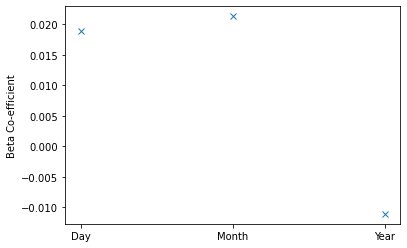

In [17]:
import matplotlib.pyplot as plt
plt.plot(['Day', "Month", 'Year'], ols.coef_, 'x')
plt.ylabel('Beta Co-efficient')

The Beta co-efficients while fitting for day, month and year. From these co-effs we come to the conclusion that the Day of the month and the exact month are very important in prediction where year has a much lower impact. The negative co-efficient for the year gives the impression that older movies have a larger reach.

Diving deeper into seprating out the months to check the impact of eacah individual month from January to December, we get the below plot

Text(0, 0.5, 'Beta Co-efficient')

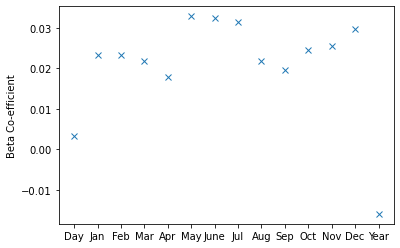

In [18]:
import matplotlib.pyplot as plt

scheme = {'Genre': DropColumn(),
          'Tags': DropColumn(),
          'Languages': DropColumn(),
          'Series or Movie': DropColumn(),
          'Country Availability': DropColumn(),
          'Runtime': DropColumn(),
          'Director': DropColumn(),
          'Writer': DropColumn(),
          'Actors': DropColumn(),
          'Awards Received': DropColumn(),
          'Awards Nominated For': DropColumn(),
          'Release Date': DateEncoding(format_string=r"%d %b %Y", month_encoding='one_hot'),
          'Netflix Release Date': DropColumn(),
          'Production House': DropColumn(),
          }
df = load_data(data_path)
imputer = DataImputer()
imputer.fit_transform(df)
encoder = DataEncoder(scheme=scheme)
x,y = encoder.fit_transform(df)
ols = LinearRegression(fit_intercept=False).fit(x, y)
plt.plot(['Day', "Jan", 'Feb', 'Mar', 'Apr', 'May', 'June', "Jul", 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Year'], ols.coef_, 'x')
plt.ylabel('Beta Co-efficient')


From these betas, we observe that movies/shows coming out in May, June July and December get higher reach thatn the rest. Whereas shows coming out in April hae the lowest reach.

## Numerical Data

We originally had a few different numerical features like critic/viewer scores, boxoffice etc. But since the goal of this project is to predict how well a new show/movie will perform in the future, it does not make sense to deal with these types of data as it is extremely unlikely to have these data. Rather they can be used to enhance/modify the dependent/resultant variable. That is something reserved for future works.

Besides these, for the rest of the numerical data, it is sensible to assume them as ordinal and they are just normalized betwwen [0, 1] and used as a feature directly without any other types of processing